In [1]:
from __future__ import print_function
import os
import argparse
import torch
import torch.backends.cudnn as cudnn
import numpy as np
# from data import cfg_mnet, cfg_re50
from layers.functions.prior_box import PriorBox
from utils.nms.py_cpu_nms import py_cpu_nms
import cv2
from models.retinaface import RetinaFace
from utils.box_utils import decode, decode_landm
from utils.timer import Timer
import matplotlib.pyplot as plt

In [2]:
def check_keys(model, pretrained_state_dict):
    ckpt_keys = set(pretrained_state_dict.keys())
    model_keys = set(model.state_dict().keys())
    used_pretrained_keys = model_keys & ckpt_keys
    unused_pretrained_keys = ckpt_keys - model_keys
    missing_keys = model_keys - ckpt_keys
    print('Missing keys:{}'.format(len(missing_keys)))
    print('Unused checkpoint keys:{}'.format(len(unused_pretrained_keys)))
    print('Used keys:{}'.format(len(used_pretrained_keys)))
    assert len(used_pretrained_keys) > 0, 'load NONE from pretrained checkpoint'
    return True


def remove_prefix(state_dict, prefix):
    ''' Old style model is stored with all names of parameters sharing common prefix 'module.' '''
    print('remove prefix \'{}\''.format(prefix))
    f = lambda x: x.split(prefix, 1)[-1] if x.startswith(prefix) else x
    return {f(key): value for key, value in state_dict.items()}


def load_model(model, pretrained_path, load_to_cpu):
    print('Loading pretrained model from {}'.format(pretrained_path))
    if load_to_cpu:
        pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage)
    else:
        device = torch.cuda.current_device()
        pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage.cuda(device))
    if "state_dict" in pretrained_dict.keys():
        pretrained_dict = remove_prefix(pretrained_dict['state_dict'], 'module.')
    else:
        pretrained_dict = remove_prefix(pretrained_dict, 'module.')
    check_keys(model, pretrained_dict)
    model.load_state_dict(pretrained_dict, strict=False)
    return model

In [3]:
torch.set_grad_enabled(False)
cfg = {
    'name': 'mobilenet0.25',
    'min_sizes': [[16, 32], [64, 128], [256, 512]],
    'steps': [8, 16, 32],
    'variance': [0.1, 0.2],
    'clip': False,
    'loc_weight': 2.0,
    'gpu_train': True,
    'batch_size': 32,
    'ngpu': 1,
    'epoch': 250,
    'decay1': 190,
    'decay2': 220,
    'image_size': 640,
    'pretrain': False,
    'return_layers': {'stage1': 1, 'stage2': 2, 'stage3': 3},
    'in_channel': 32,
    'out_channel': 64
}

# net and model
net = RetinaFace(cfg=cfg, phase = 'test')
net = load_model(net, "weights/mobilenet0.25_Final.pth", True)
net.eval()
print('Finished loading model!')
print(net)
cudnn.benchmark = True
device = torch.device("cpu" if True else "cuda")
net = net.to(device)

Loading pretrained model from weights/mobilenet0.25_Final.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:300
Finished loading model!
RetinaFace(
  (body): IntermediateLayerGetter(
    (stage1): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): LeakyReLU(negative_slope=0.1, inplace=True)

C:\Users\four\AppData\Local\Temp\ipykernel_8576\1036366865.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(pretrained_path, map_location=la

In [4]:
def detect_faces(img_raw,vis_thres=0.5):
    if(type(img_raw)==str):
        img_raw = cv2.imread(img_raw, cv2.IMREAD_COLOR)
    img = np.float32(img_raw)
    im_height, im_width, _ = img.shape
    scale = torch.Tensor([img.shape[1], img.shape[0], img.shape[1], img.shape[0]])
    img -= (104, 117, 123)
    img = img.transpose(2, 0, 1)
    img = torch.from_numpy(img).unsqueeze(0)
    img = img.to(device)
    scale = scale.to(device)
    _t = {'forward_pass': Timer(), 'misc': Timer()}
    resize = 1

    _t['forward_pass'].tic()
    loc, conf, landms = net(img)  # forward pass
    _t['forward_pass'].toc()
    _t['misc'].tic()
    priorbox = PriorBox(cfg, image_size=(im_height, im_width))
    priors = priorbox.forward()
    priors = priors.to(device)
    prior_data = priors.data
    boxes = decode(loc.data.squeeze(0), prior_data, cfg['variance'])
    boxes = boxes * scale / resize
    boxes = boxes.cpu().numpy()
    scores = conf.squeeze(0).data.cpu().numpy()[:, 1]
    landms = decode_landm(landms.data.squeeze(0), prior_data, cfg['variance'])
    scale1 = torch.Tensor([img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                            img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                            img.shape[3], img.shape[2]])
    scale1 = scale1.to(device)
    landms = landms * scale1 / resize
    landms = landms.cpu().numpy()

    # ignore low scores
    inds = np.where(scores > 0.02)[0]
    boxes = boxes[inds]
    landms = landms[inds]
    scores = scores[inds]

    # keep top-K before NMS
    # order = scores.argsort()[::-1][:args.top_k]
    order = scores.argsort()[::-1]
    boxes = boxes[order]
    landms = landms[order]
    scores = scores[order]

    # do NMS
    dets = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32, copy=False)
    keep = py_cpu_nms(dets, 0.4)

    dets = dets[keep, :]
    landms = landms[keep]

    # keep top-K faster NMS
    # dets = dets[:args.keep_top_k, :]
    # landms = landms[:args.keep_top_k, :]

    dets = np.concatenate((dets, landms), axis=1)
    facess  = []
    for b in dets:
        if b[4] < vis_thres:
            continue
        xs = b[4]
        b = list(map(int, b))
        b.append(xs)
        facess.append(b)

    return facess

In [18]:
import cv2

def draw_faces_landmarks(image_path, faces_data, output_image_path=None):
    image = cv2.imread(image_path)
    for  face_data in faces_data:
        x1, y1, x2, y2 =face_data[0:4]
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue box

        for item in range(5,15,2):
            cv2.circle(image, (int(face_data[item]), int(face_data[item+1])), 1, (0, 0, 255), 4)  # Red dots

    # Save the image with bounding boxes and landmarks
    if(output_image_path):
        cv2.imwrite(output_image_path, image)
        print(f"Image saved to {output_image_path}")
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')  # Tắt hiển thị trục
        plt.tight_layout()
        plt.show()

38
[[207, 102, 235, 138, 0, 215, 115, 229, 116, 222, 122, 215, 128, 226, 129, np.float32(0.9996455)], [203, 218, 238, 262, 0, 215, 234, 231, 234, 225, 242, 217, 250, 229, 250, np.float32(0.99943644)], [108, 449, 157, 510, 0, 123, 471, 145, 473, 134, 486, 123, 494, 142, 495, np.float32(0.9993212)], [611, 87, 640, 125, 0, 617, 102, 630, 102, 623, 109, 619, 115, 630, 115, np.float32(0.9992718)], [390, 176, 422, 219, 0, 403, 192, 416, 194, 410, 201, 402, 208, 413, 209, np.float32(0.999246)], [153, 87, 181, 123, 0, 161, 101, 174, 100, 168, 107, 163, 114, 174, 114, np.float32(0.99909616)], [700, 82, 729, 119, 0, 706, 96, 718, 96, 710, 102, 707, 109, 717, 109, np.float32(0.99887747)], [171, 32, 197, 64, 0, 180, 43, 191, 44, 186, 49, 180, 55, 189, 55, np.float32(0.9988281)], [364, 93, 391, 128, 0, 370, 107, 383, 106, 376, 113, 371, 120, 382, 120, np.float32(0.9987777)], [597, 24, 621, 58, 0, 599, 37, 609, 37, 602, 43, 601, 50, 609, 50, np.float32(0.9986094)], [129, 203, 167, 250, 0, 140, 220, 

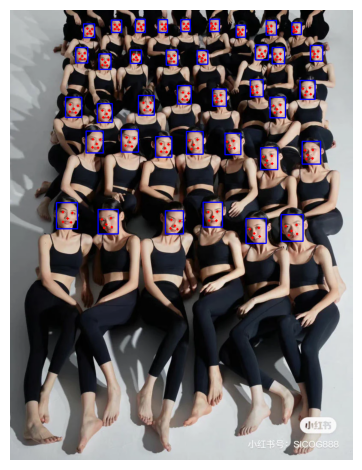

In [21]:
image_path = "c:/Users/four/Downloads/tao-dang-chup-anh-tap-the__31__80f9aa9490ee4d3f838d09a140562638.webp"
# img_raw = cv2.imread(image_path, cv2.IMREAD_COLOR)
facess = detect_faces(image_path)
print(len(facess))
print(facess)
draw_faces_landmarks(image_path,facess)

In [22]:

# Các cấu hình cần thiết như 'cfg', 'net', và 'device' cần được định nghĩa từ trước

def detect_from_webcam():
    cap = cv2.VideoCapture(0)  # Mở webcam

    while True:
        ret, img_raw = cap.read()  # Đọc từng khung hình từ webcam
        if not ret:
            break
        data_faces = detect_faces(img_raw)
        for b in data_faces:
            cv2.rectangle(img_raw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 2)
            cx = b[0]
            cy = b[1] + 12
            cv2.putText(img_raw, f"{(int(b[15]*10000))/10000}", (cx, cy),
                        cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255))

            # Vẽ các landmarks
            cv2.circle(img_raw, (b[5], b[6]), 1, (0, 0, 255), 4)
            cv2.circle(img_raw, (b[7], b[8]), 1, (0, 255, 255), 4)
            cv2.circle(img_raw, (b[9], b[10]), 1, (255, 0, 255), 4)
            cv2.circle(img_raw, (b[11], b[12]), 1, (0, 255, 0), 4)
            cv2.circle(img_raw, (b[13], b[14]), 1, (255, 0, 0), 4)

        # Hiển thị khung hình
        cv2.imshow('Webcam Detection', img_raw)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Chạy hàm phát hiện từ webcam
if False: detect_from_webcam()
